# XSVS pipeline

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler

In [2]:
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

class FixedEigerImages(EigerImages):
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs

    def __init__(self, fpath, frame_per_point):
        # create pims handler
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        # TODO Return a multi-dimensional PIMS seq.
        return FixedEigerImages(master_path)

register_handler('AD_EIGER', LazyEigerHandler)  # Register it so filestore knows to use it.

In [5]:
events = get_events(db['e59f567d'], ['eiger_4M_cam_img_image_lightfield'])
ev = next(events)

imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
imgs

<Frames>
Length: 3000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Interactive way to browse through images.
Note : Provide the number of images that you want to browse

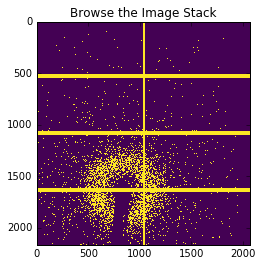

In [10]:
from ipywidgets import interact
%matplotlib inline
def view_image(i):
    plt.imshow(imgs[i], interpolation='nearest', cmap='viridis', vmin=0, vmax=1e0)
    plt.title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, 2999))

## Get the Averaged Image Data

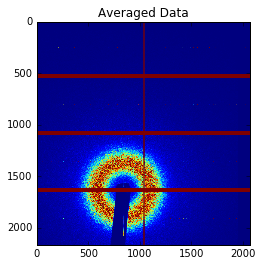

In [20]:
avg_img = np.average(imgs, axis=0)

# Plot the result
fig, ax = plt.subplots()
ax.imshow(avg_img, vmin=0, vmax=1e0)
ax.set_title("Averaged Data")
plt.show()

## Note:  Enter the following experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [11]:
# The physical size of the pixels
dpix = 0.075  
 
lambda_ = 1.5498    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance

exposuretime= 100 * 10**(-3) 
acquisition_period = 100 * 10**(-3)  

#deadtime= 0   # 60e-6 
#timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision

In [16]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi
import skxray.core.speckle as speckle
import skxray.core.utils as utils

## Input the mask file

In [12]:
cd Analysis_Pipelines/

/home/sameera/Analysis_Pipelines


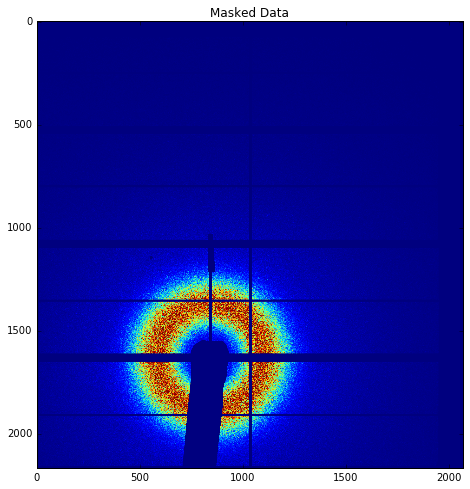

In [21]:
%matplotlib inline

mask = ~np.load("./mask2.npy")

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(avg_img*mask, vmin=0, vmax=1e0)
ax.set_title("Masked Data")
plt.show()

# Get the approximate center and see the statistic to make sure

In [22]:
center = (1634.66, 838.6)  # center of the speckle pattern

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [23]:
bin_centers, ring_averages= roi.circular_average(avg_img*mask, center, threshold=0, nx=100,
                                         pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

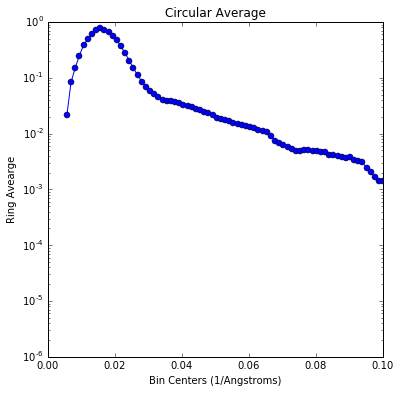

In [24]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
plt.show()

## Create label array (Q rings)

In [25]:
inner_radius = 100# radius of the first ring
width = 10        # width of each ring
spacing = 3      # no spacing between rings
num_rings = 15   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 100.,  110.],
       [ 113.,  123.],
       [ 126.,  136.],
       [ 139.,  149.],
       [ 152.,  162.],
       [ 165.,  175.],
       [ 178.,  188.],
       [ 191.,  201.],
       [ 204.,  214.],
       [ 217.,  227.],
       [ 230.,  240.],
       [ 243.,  253.],
       [ 256.,  266.],
       [ 269.,  279.],
       [ 282.,  292.]])

In [26]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_val

array([[ 0.00608128,  0.00668941],
       [ 0.00687185,  0.00747997],
       [ 0.00766241,  0.00827054],
       [ 0.00845297,  0.0090611 ],
       [ 0.00924354,  0.00985166],
       [ 0.0100341 ,  0.01064222],
       [ 0.01082466,  0.01143278],
       [ 0.01161522,  0.01222334],
       [ 0.01240578,  0.0130139 ],
       [ 0.01319634,  0.01380446],
       [ 0.0139869 ,  0.01459502],
       [ 0.01477745,  0.01538557],
       [ 0.01556801,  0.01617613],
       [ 0.01635856,  0.01696668],
       [ 0.01714911,  0.01775723]])

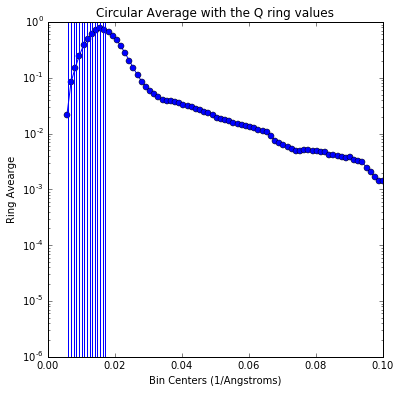

In [27]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average with the Q ring values")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
for i in range(num_rings):
    axes.axvline(q_ring_val[i, 0])
plt.show()

<IPython.core.display.Javascript object>


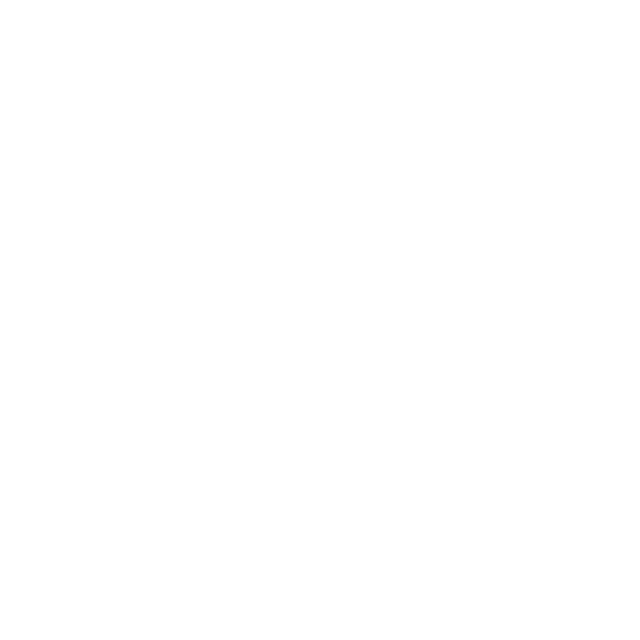

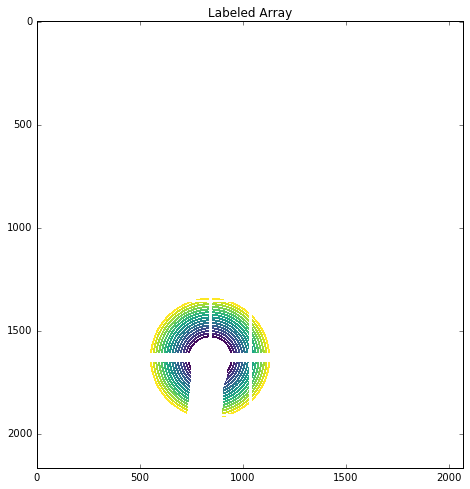

In [28]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask
% matplotlib notebook
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis')
plt.show()

##  Mean intensities for each ring

In [29]:
mask_data = imgs*mask
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

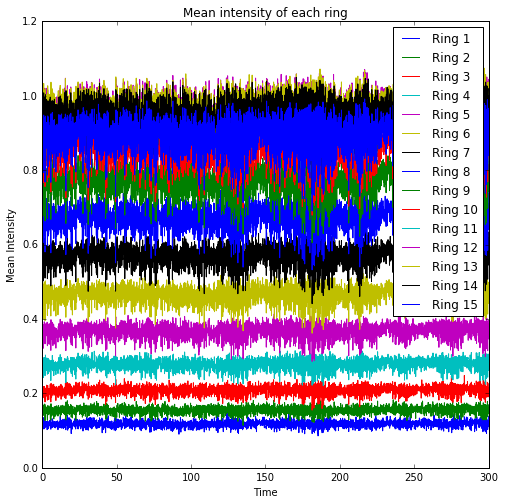

In [30]:
time = np.arange(len(imgs))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

In [31]:
mask_data.shape

(3000, 2167, 2070)

### Find the brightest pixel in any ROI in any image in the image set.
Using roi_max_counts function from skxray.core.roi module

In [ ]:
max_cts = roi.roi_max_counts(mask_data, ring_mask)
max_cts

## XSVS analysis

In [32]:
spe_cts_all, std_dev = speckle.xsvs(mask_data, ring_mask, timebin_num=2,
                             number_of_img=30, max_cts=max_cts)

NameError: name 'max_cts' is not defined